🤖 Fraud Detection - Machine Learning Model Development
📁 Loading cleaned data...
Dataset shape: (50000, 31)
Fraud rate: 0.1933 (19.33%)

🎯 1. Feature Engineering
Feature matrix shape: (50000, 15)
Target distribution:
is_fraud
0    40333
1     9667
Name: count, dtype: int64

🔤 Encoding categorical variables...
  category: 8 categories
  device_used: 3 categories

⚖️ 2. Handling Class Imbalance
Non-fraud cases: 40,333
Fraud cases: 9,667
Imbalance ratio: 4.2:1

📊 3. Train-Test Split
Training set: (35000, 15)
Test set: (15000, 15)
Training fraud rate: 0.1933
Test fraud rate: 0.1933
Numeric columns to impute/scale: ['amount', 'hour_of_day', 'category', 'device_used', 'account_age_days', 'transaction_count', 'avg_amount', 'std_amount', 'max_amount', 'transaction_frequency', 'amount_to_avg_ratio', 'is_high_value', 'is_late_night', 'is_international', 'is_weekend']

📏 4. Feature Scaling

🤖 5. Model Training

Training Logistic Regression...
  CV AUC: 0.5383 (+/- 0.0097)
  Test AUC: 0.5383

Trai

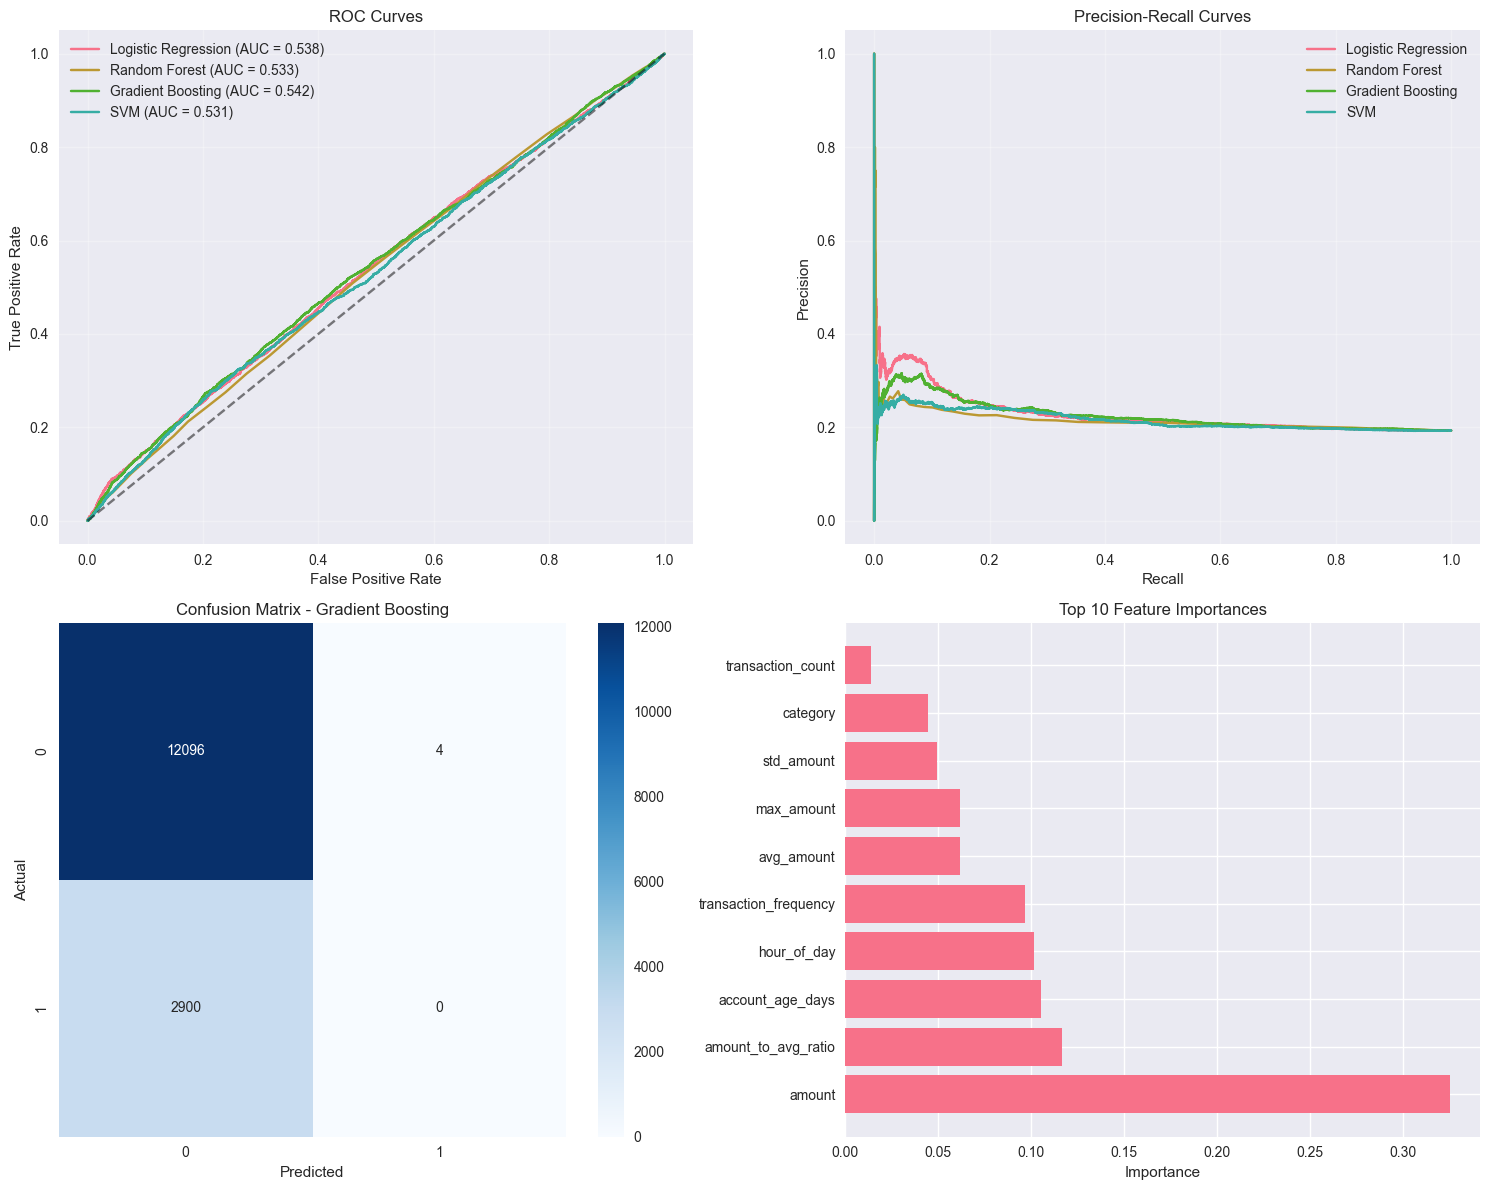


🎯 9. Threshold Optimization
Optimal threshold: 0.10
Optimal F1-score: 0.3238


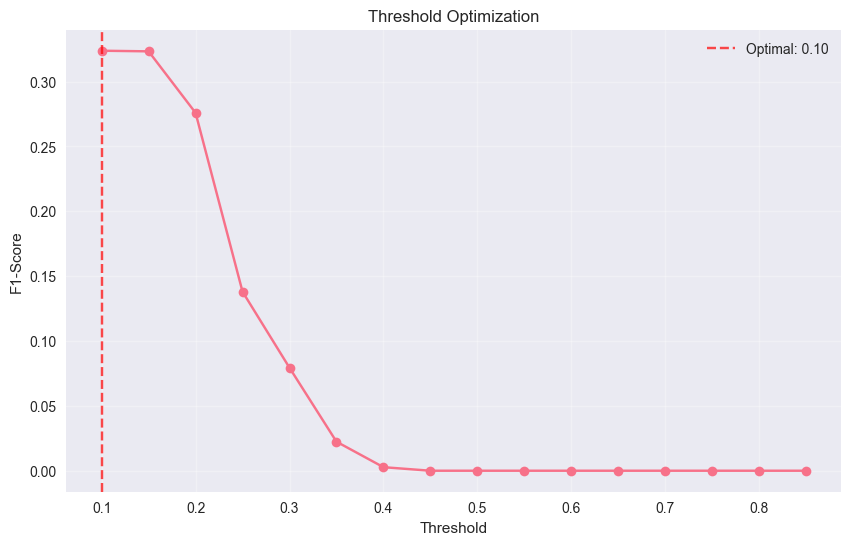


💼 10. Business Impact Analysis
True Positives (Fraud Caught): 2897
False Positives (False Alarms): 12097
False Negatives (Missed Fraud): 3
Average Fraud Amount: $207.84
Fraud Value Prevented: $602107.29
Investigation Cost: $149940.00
Net Fraud Loss Prevented: $452167.29

💾 11. Saving the Model
✅ Model artifacts saved to '../models/fraud_detection_model.pkl'

🚀 12. Model Deployment Preparation
Sample prediction - Fraud probability: 0.9151, Is fraud: True

✅ Fraud detection model development completed!
🎯 Next: Build the Streamlit dashboard for real-time fraud detection


In [1]:
# Fraud Detection - Machine Learning Model Development

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
 )
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings("ignore")

# Setup
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)

print("🤖 Fraud Detection - Machine Learning Model Development")
print("=" * 65)

# Load cleaned data
print("📁 Loading cleaned data...")
fraud_data = pd.read_csv("../../data/processed/fraud_data_clean.csv")
fraud_data["transaction_date"] = pd.to_datetime(fraud_data["transaction_date"])

print(f"Dataset shape: {fraud_data.shape}")
print(
    f"Fraud rate: {fraud_data['is_fraud'].mean():.4f} ({fraud_data['is_fraud'].mean():.2%})"
 )

# 1. Feature Engineering
print("\n🎯 1. Feature Engineering")

# Select and prepare features
features_to_use = [
    # Transaction features
    "amount",
    "hour_of_day",
    "category",
    "location",
    "device_used",
    # User behavior features
    "account_age_days",
    "transaction_count",
    "avg_amount",
    "std_amount",
    "max_amount",
    "transaction_frequency",
    # Derived features
    "amount_to_avg_ratio",
    "is_high_value",
    "is_late_night",
    "is_international",
    "is_weekend",
 ]

# Filter out features that don't exist in the dataframe to avoid KeyError
available_features = [f for f in features_to_use if f in fraud_data.columns]
missing_features = [f for f in features_to_use if f not in fraud_data.columns]
if missing_features:
    print(f"Warning: The following features were not found in the data and will be skipped: {missing_features}")
features_to_use = available_features

# Create feature matrix (now safe)
X = fraud_data[features_to_use].copy()
y = fraud_data["is_fraud"]

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Encode categorical variables (only those present)
print("\n🔤 Encoding categorical variables...")
possible_categorical = ["category", "location", "device_used"]
categorical_columns = [c for c in possible_categorical if c in X.columns]
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    # convert to str to avoid issues with NaN and mixed types
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} categories")

# 2. Handle Class Imbalance
print("\n⚖️ 2. Handling Class Imbalance")

# Since fraud detection is highly imbalanced, we'll use class weights and proper evaluation metrics
# For simplicity, we'll use class weights and careful evaluation
fraud_count = y.sum()
non_fraud_count = len(y) - fraud_count

print(f"Non-fraud cases: {non_fraud_count:,}")
print(f"Fraud cases: {fraud_count:,}")
if fraud_count > 0:
    print(f"Imbalance ratio: {non_fraud_count/fraud_count:.1f}:1")
else:
    print("Warning: no fraud cases found in data")

# 3. Train-Test Split with Stratification
print("\n📊 3. Train-Test Split")

# If y has only one class, train_test_split with stratify will fail — guard against that
if y.nunique() < 2:
    raise ValueError("Target 'is_fraud' contains less than 2 classes; cannot stratify split.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y,
 )

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")

# Handle infinities and missing numeric values using an imputer (fit on train only)
# Replace infinities with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Numeric columns to impute (includes any label-encoded categorical columns too)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns to impute/scale: {numeric_cols}")

imputer = SimpleImputer(strategy="median")
if len(numeric_cols) > 0:
    X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])
else:
    # nothing numeric to impute
    pass

# Save copies for tree-based models (full feature matrices)
X_train_full = X_train.copy()
X_test_full = X_test.copy()

# 4. Feature Scaling
print("\n📏 4. Feature Scaling")

scaler = StandardScaler()
# Scale numeric columns (LabelEncoded categorical columns are numeric now)
if len(numeric_cols) > 0:
    X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled = scaler.transform(X_test[numeric_cols])
else:
    X_train_scaled = np.empty((len(X_train), 0))
    X_test_scaled = np.empty((len(X_test), 0))

# 5. Model Training
print("\n🤖 5. Model Training")

models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced", random_state=42, n_estimators=100
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "SVM": SVC(class_weight="balanced", probability=True, random_state=42),
 }

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name == "SVM":
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train_full
        X_test_model = X_test_full

    # Cross-validation (use numeric subset or full depending on model)
    try:
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv, scoring="roc_auc")
    except Exception as e:
        print(f"  CV error for {name}: {e}")
        cv_scores = np.array([np.nan])

    # Train model
    model.fit(X_train_model, y_train)

    # Predictions
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    else:
        # some models use decision_function
        try:
            y_pred_proba = model.decision_function(X_test_model)
            # scale to 0-1 using minmax if needed
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min() + 1e-12)
        except Exception:
            y_pred_proba = np.zeros(len(y_test))

    y_pred = (y_pred_proba > 0.5).astype(int)

    # Store results
    results[name] = {
        "model": model,
        "cv_auc_mean": np.nanmean(cv_scores),
        "cv_auc_std": np.nanstd(cv_scores),
        "test_auc": roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test))>1 else np.nan,
        "y_pred_proba": y_pred_proba,
        "y_pred": y_pred,
    }

    print(f"  CV AUC: {results[name]['cv_auc_mean']:.4f} (+/- {results[name]['cv_auc_std'] * 2:.4f})")
    if not np.isnan(results[name]['test_auc']):
        print(f"  Test AUC: {results[name]['test_auc']:.4f}")
    else:
        print("  Test AUC: N/A (single-class test set)")

# 6. Model Comparison
print("\n📊 6. Model Comparison")

comparison_df = pd.DataFrame(
    {
        "Model": list(results.keys()),
        "CV AUC Mean": [results[name]["cv_auc_mean"] for name in results.keys()],
        "CV AUC Std": [results[name]["cv_auc_std"] for name in results.keys()],
        "Test AUC": [results[name]["test_auc"] for name in results.keys()],
    }
).sort_values("Test AUC", ascending=False)

print(comparison_df)

# 7. Best Model Analysis
print("\n🏆 7. Best Model Analysis")

best_model_name = comparison_df.iloc[0]["Model"] if not comparison_df.empty else None
if best_model_name is None:
    raise RuntimeError("No trained models found to analyze")

best_model = results[best_model_name]["model"]
best_y_pred_proba = results[best_model_name]["y_pred_proba"]
best_y_pred = results[best_model_name]["y_pred"]

print(f"Best model: {best_model_name}")
print(f"Test AUC: {results[best_model_name]['test_auc']:.4f}")

# Detailed classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, best_y_pred, target_names=["Non-Fraud", "Fraud"]))

# 8. Visualization of Results
print("\n📈 8. Model Performance Visualization")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result["y_pred_proba"])
    auc_score = result["test_auc"]
    axes[0, 0].plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

axes[0, 0].plot([0, 1], [0, 1], "k--", alpha=0.5)
axes[0, 0].set_xlabel("False Positive Rate")
axes[0, 0].set_ylabel("True Positive Rate")
axes[0, 0].set_title("ROC Curves")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curve
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result["y_pred_proba"])
    axes[0, 1].plot(recall, precision, label=f"{name}")

axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("Precision-Recall Curves")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix for best model
cm = confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[1, 0])
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("Actual")
axes[1, 0].set_title(f"Confusion Matrix - {best_model_name}")

# Feature Importance (if available)
if hasattr(best_model, "feature_importances_") and hasattr(X, 'columns'):
    feature_importance = pd.DataFrame(
        {"feature": X.columns, "importance": best_model.feature_importances_}
    ).sort_values("importance", ascending=False)

    axes[1, 1].barh(
        feature_importance["feature"][:10], feature_importance["importance"][:10],
    )
    axes[1, 1].set_title("Top 10 Feature Importances")
    axes[1, 1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

# 9. Threshold Optimization
print("\n🎯 9. Threshold Optimization")

from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred_opt = (best_y_pred_proba > threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_opt))

optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_f1 = np.max(f1_scores)

print(f"Optimal threshold: {optimal_threshold:.2f}")
print(f"Optimal F1-score: {optimal_f1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker="o")
plt.axvline(
    optimal_threshold,
    color="red",
    linestyle="--",
    alpha=0.7,
    label=f"Optimal: {optimal_threshold:.2f}",
 )
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("Threshold Optimization")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 10. Business Impact Analysis
print("\n💼 10. Business Impact Analysis")

# Calculate with optimal threshold
y_pred_optimal = (best_y_pred_proba > optimal_threshold).astype(int)

# Financial impact assumptions
avg_fraud_amount = fraud_data[fraud_data["is_fraud"] == 1]["amount"].mean() if "amount" in fraud_data.columns else 0
investigation_cost = 10  # Cost to investigate each flagged transaction

# Calculate metrics
true_positives = ((y_pred_optimal == 1) & (y_test == 1)).sum()
false_positives = ((y_pred_optimal == 1) & (y_test == 0)).sum()
false_negatives = ((y_pred_optimal == 0) & (y_test == 1)).sum()

fraud_prevented_value = true_positives * (avg_fraud_amount if not np.isnan(avg_fraud_amount) else 0)
investigation_cost_total = (true_positives + false_positives) * investigation_cost
fraud_loss_prevented = fraud_prevented_value - investigation_cost_total

print(f"True Positives (Fraud Caught): {true_positives}")
print(f"False Positives (False Alarms): {false_positives}")
print(f"False Negatives (Missed Fraud): {false_negatives}")
print(f"Average Fraud Amount: ${avg_fraud_amount:.2f}")
print(f"Fraud Value Prevented: ${fraud_prevented_value:.2f}")
print(f"Investigation Cost: ${investigation_cost_total:.2f}")
print(f"Net Fraud Loss Prevented: ${fraud_loss_prevented:.2f}")

# 11. Save the Model
print("\n💾 11. Saving the Model")

import joblib
import os

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Save model, scaler, imputer and encoders
model_artifacts = {
    "model": best_model,
    "scaler": scaler,
    "imputer": imputer,
    "label_encoders": label_encoders,
    "features": features_to_use,
    "optimal_threshold": optimal_threshold,
}

joblib.dump(model_artifacts, "../models/fraud_detection_model.pkl")

print("✅ Model artifacts saved to '../models/fraud_detection_model.pkl'")

# 12. Model Deployment Preparation
print("\n🚀 12. Model Deployment Preparation")

# Create a prediction function for the dashboard
def predict_fraud(transaction_data, model_artifacts):
    """
    Predict fraud probability for a single transaction
    """
    model = model_artifacts["model"]
    scaler = model_artifacts.get("scaler")
    imputer = model_artifacts.get("imputer")
    label_encoders = model_artifacts.get("label_encoders", {})
    features = model_artifacts["features"]

    # Prepare the input data
    input_df = pd.DataFrame([transaction_data])

    # Encode categorical variables (handle unseen categories)
    for col, encoder in label_encoders.items():
        if col in input_df.columns:
            try:
                input_df[col] = encoder.transform(input_df[col].astype(str))
            except ValueError:
                # unseen category -> assign special value (e.g., -1)
                input_df[col] = -1
        else:
            input_df[col] = -1

    # Ensure all features are present
    for feature in features:
        if feature not in input_df.columns:
            input_df[feature] = 0

    # Select features in correct order
    input_df = input_df[features]

    # Replace infinities and impute numeric columns if imputer available
    input_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_cols_in_input = input_df.select_dtypes(include=[np.number]).columns.tolist()
    if imputer is not None and len(numeric_cols_in_input) > 0:
        input_df[numeric_cols_in_input] = imputer.transform(input_df[numeric_cols_in_input])

    # Scale numeric features if scaler available
    if scaler is not None and len(numeric_cols_in_input) > 0:
        input_df[numeric_cols_in_input] = scaler.transform(input_df[numeric_cols_in_input])

    # Predict (handle models without predict_proba)
    if hasattr(model, "predict_proba"):
        fraud_probability = model.predict_proba(input_df)[:, 1][0]
    else:
        try:
            prob = model.decision_function(input_df)
            prob = (prob - prob.min()) / (prob.max() - prob.min() + 1e-12)
            fraud_probability = prob[0]
        except Exception:
            fraud_probability = 0.0

    is_fraud = fraud_probability > model_artifacts.get("optimal_threshold", 0.5)

    return fraud_probability, is_fraud

# Test the prediction function (only if model artifacts are available)
if 'model_artifacts' in globals():
    sample_transaction = {
        "amount": 250.0,
        "hour_of_day": 3,
        "category": "Travel",
        "location": "International",
        "device_used": "Mobile",
        "account_age_days": 15,
        "transaction_count": 5,
        "avg_amount": 100.0,
        "std_amount": 50.0,
        "max_amount": 300.0,
        "transaction_frequency": 0.33,
        "amount_to_avg_ratio": 2.5,
        "is_high_value": 1,
        "is_late_night": 1,
        "is_international": 1,
        "is_weekend": 0,
    }

    try:
        fraud_prob, is_fraud_pred = predict_fraud(sample_transaction, model_artifacts)
        print(
            f"Sample prediction - Fraud probability: {fraud_prob:.4f}, Is fraud: {is_fraud_pred}")
    except Exception as e:
        print(f"Sample prediction skipped due to error: {e}")

print("\n✅ Fraud detection model development completed!")
print("🎯 Next: Build the Streamlit dashboard for real-time fraud detection")